## Notebook for sampling peatland data

Requirements:

- polygons within which to sample satellite data
- point grid
- corresponding satellite data (.tif format)

Directory structure is simple:

- created a holding folder (called it 'peatland_sampling')
- this notebook inside peatland_sampling
- folder called 'shapefile_and_point_grid' with - you guessed it - polygon and .tif files


You should be able to plug and play this notebook if you use that structure. If you change folder names, change corresponding stuff below.


### Establish current working directory

(Inside the project folder)

In [1]:
# sorting out working directory
import os

# Get the current working directory
current_directory = os.getcwd()

# Print the current working directory
print("Current Working Directory:", current_directory)

Current Working Directory: c:\Users\klara\OneDrive\Skrivebord\peatland_sampling


### Imports

In [1]:
from rasterio.plot import show
import matplotlib.pyplot as plt
import geopandas as gpd
import rasterio
import rasterio.mask
import numpy as np
import pandas as pd

### check contents of the folder

In [577]:
# Specify the path to the folder
folder_path = "2023"

# Check if the folder exists
if os.path.exists(folder_path) and os.path.isdir(folder_path):
    # List all files in the folder
    files = os.listdir(folder_path)

    if files:
        print("Files in the '2023' folder:")
        for file in files:
            print(file)
    else:
        print("The '2023' folder is empty.")
else:
    print("The '2023' folder does not exist in the current working directory.")


Files in the '2023' folder:
aoi_2023_1
aoi_2023_10
aoi_2023_11
aoi_2023_12
aoi_2023_2
aoi_2023_3
aoi_2023_4
aoi_2023_5
aoi_2023_6
aoi_2023_7
aoi_2023_8
aoi_2023_9


### Check out point grid file and .tif

In [5]:
# Load the point grid shapefile
point_grid_path = "2018/aoi_2018_1/bare_peat_aoi_1_gridpoints.shp"
initial_point_grid_gdf = gpd.read_file(point_grid_path)

# Load the TIFF raster file
tiff_path = "2018/aoi_2018_1/Composite_2018_AOI_1.tif"
src = rasterio.open(tiff_path)

# Print .tif dimensions, number of bands, and most immportantly CRS
print("Raster Dimensions (width x height):", src.width, "x", src.height)
print("Number of Bands:", src.count)
print("Coordinate Reference System (CRS):", src.crs)

# Check the CRS of the point grid shapefile
print("CRS of Point Grid Shapefile:", initial_point_grid_gdf.crs)

# Check the first few rows of the point grid DataFrame
print("Sneak peek of point grid file:")
print(initial_point_grid_gdf.head())

# Check the geometry column to see if it contains point coordinates
print(initial_point_grid_gdf.geometry.head())



Raster Dimensions (width x height): 1714 x 1230
Number of Bands: 23
Coordinate Reference System (CRS): EPSG:4326
CRS of Point Grid Shapefile: EPSG:3857
Sneak peek of point grid file:
       FID  Id                         geometry
0  1356647   0  POINT (-365669.982 7515610.736)
1  1787002   0  POINT (-359404.982 7517005.736)
2   309446   0  POINT (-364784.982 7512205.736)
3  1243016   0  POINT (-364764.982 7515240.736)
4  1227575   0  POINT (-365069.982 7515190.736)
0    POINT (-365669.982 7515610.736)
1    POINT (-359404.982 7517005.736)
2    POINT (-364784.982 7512205.736)
3    POINT (-364764.982 7515240.736)
4    POINT (-365069.982 7515190.736)
Name: geometry, dtype: geometry


### Run this cell if .tif and point grid CRS are different.

This assumes the .tif and point grid files I got were representative of all others, i.e. 

- tif crs 4326
- point grid crs something else (was 3857, not sure it matters since it gets changed anyway)

In [6]:
# Reproject the point grid to EPSG:4326
point_grid_gdf = initial_point_grid_gdf.to_crs(epsg=4326)

# Check the CRS after reprojection
print("CRS of Reprojected Point Grid Shapefile:", point_grid_gdf.crs)

point_grid_gdf.head

CRS of Reprojected Point Grid Shapefile: EPSG:4326


<bound method NDFrame.head of             FID  Id                   geometry
0       1356647   0  POINT (-3.28487 55.78438)
1       1787002   0  POINT (-3.22859 55.79142)
2        309446   0  POINT (-3.27692 55.76718)
3       1243016   0  POINT (-3.27674 55.78251)
4       1227575   0  POINT (-3.27948 55.78226)
...         ...  ..                        ...
329333  1487612   0  POINT (-3.27431 55.78653)
329334   459983   0  POINT (-3.28532 55.76965)
329335  1749043   0  POINT (-3.27562 55.79082)
329336  1961246   0  POINT (-3.27746 55.79430)
329337  1894717   0  POINT (-3.22612 55.79319)

[329338 rows x 3 columns]>

### Optional: inspect .tif file

In [580]:
# Count the number of points in point_grid_gdf
num_points = len(point_grid_gdf)
print("Number of Points in point_grid_gdf:", num_points)

# Count the number of pixels in the TIFF
num_pixels = src.width * src.height
print("Number of Pixels in the TIFF:", num_pixels)

# Print out the bands of the TIFF
num_bands = src.count
print("Number of Bands in the TIFF:", num_bands)

# Get the names of the bands in the TIFF file
band_names = src.descriptions

# Print out the names of the bands
print("Names of Bands in the TIFF:")
for band_index, band_name in enumerate(band_names, start=1):
    print(f"Band {band_index}: {band_name}")


Number of Points in point_grid_gdf: 148500
Number of Pixels in the TIFF: 4812048
Number of Bands in the TIFF: 23
Names of Bands in the TIFF:
Band 1: B1
Band 2: B2
Band 3: B3
Band 4: B4
Band 5: B5
Band 6: B6
Band 7: B7
Band 8: B8
Band 9: B8A
Band 10: B9
Band 11: B11
Band 12: B12
Band 13: AOT
Band 14: WVP
Band 15: SCL
Band 16: TCI_R
Band 17: TCI_G
Band 18: TCI_B
Band 19: MSK_CLDPRB
Band 20: MSK_SNWPRB
Band 21: QA10
Band 22: QA20
Band 23: QA60


### Visualize .tif and polygon on top of each other

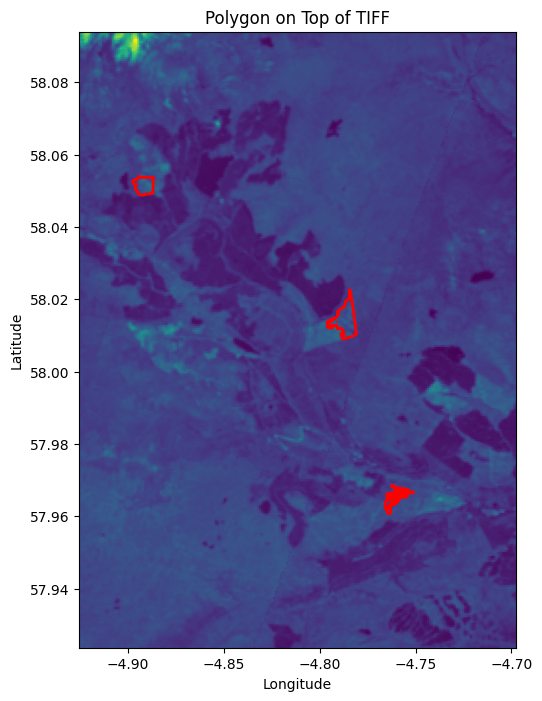

In [581]:
# Load the polygon shapefile
shape_path = "2023/aoi_2023_11/restored_2023_AOI_11.shp"
polygon_gdf = gpd.read_file(shape_path)

# Load the TIFF raster file
tiff_path = "2023/aoi_2023_11/Composite_2023_AOI_11.tif"
with rasterio.open(tiff_path) as src:
    # Check if CRS of polygon and raster match
    if polygon_gdf.crs != src.crs:
        # Reproject polygon to match raster CRS
        polygon_gdf = polygon_gdf.to_crs(src.crs)
    
    # Plot the TIFF raster and GeoJSON polygons together
    fig, ax = plt.subplots(figsize=(8, 8))
    show(src, cmap='viridis', ax=ax)  # Adjust colormap as needed
    polygon_gdf.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=2)

    # Customize the plot
    plt.title("Polygon on Top of TIFF")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()

### Subsequently plot point grid, polygon and .tif

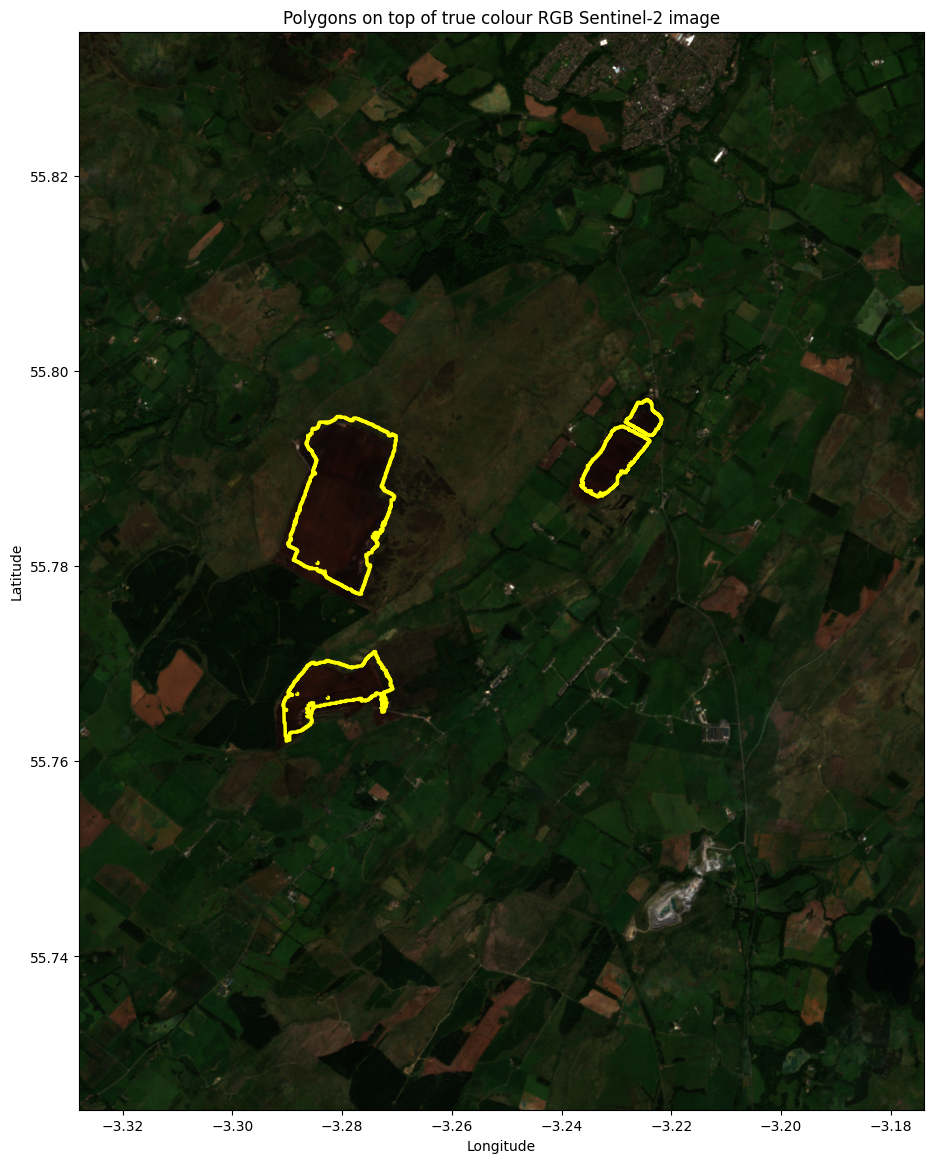

In [18]:
# Load the polygon shapefile
shape_path = "2018/aoi_2018_1/bare_peat_2018_AOI_1.shp"
polygon_gdf = gpd.read_file(shape_path)

# Function to normalize and apply gamma correction
def normalize_and_gamma(band, min_val, max_val, gamma):
    band = np.clip(band, min_val, max_val)
    band = (band - min_val) / (max_val - min_val)
    band = np.power(band, gamma)
    return band

# Load the TIFF raster file
tiff_path = "2018/aoi_2018_1/Composite_2018_AOI_1.tif"
with rasterio.open(tiff_path) as src:
    # Check if CRS of polygon and raster match
    if polygon_gdf.crs != src.crs:
        # Reproject polygon to match raster CRS
        polygon_gdf = polygon_gdf.to_crs(src.crs)

    # Reproject the point grid to match raster CRS
    # Assuming point_grid_gdf is already defined
    if point_grid_gdf.crs != src.crs:
        point_grid_gdf = point_grid_gdf.to_crs(src.crs)


    # Define min and max values and gamma
    min_val, max_val = 0.001, 0.3000  # adjust based on your data
    gamma = 1.4  # adjust based on your preference

    # Read and process each band within the 'with' block
    red = normalize_and_gamma(src.read(4).astype(float), min_val, max_val, gamma)
    green = normalize_and_gamma(src.read(3).astype(float), min_val, max_val, gamma)
    blue = normalize_and_gamma(src.read(2).astype(float), min_val, max_val, gamma)

# Stack the bands into a single array
rgb = np.dstack((red, green, blue))

# Get the bounds of the raster
bounds = src.bounds
extent = [bounds.left, bounds.right,
bounds.bottom, bounds.top]

# Plot the RGB image
fig, ax = plt.subplots(figsize=(14, 14))

# Display the RGB image with correct aspect ratio
ax.imshow(rgb, extent=extent, aspect='equal')

#Plot the polygon with increased visibility
if not polygon_gdf.empty:
    polygon_gdf.plot(ax=ax, facecolor='none', edgecolor='yellow', linewidth=2.5)
#point_grid_gdf.plot(ax=ax, marker='o', color='yellow', markersize=5)  # Customize marker style

plt.title("Polygons and point grid on top of true colour RGB Sentinel-2 image")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

## Sample

### each band should have its own column

In [13]:
# Load the reprojected point grid shapefile

# Load the TIFF raster file
tiff_path = "2018/aoi_2018_1/Composite_2018_AOI_1.tif"
src = rasterio.open(tiff_path)

# Initialize a dictionary to store sampled pixel values for each band
band_pixel_values = {band_name: [] for band_name in src.descriptions}

# Iterate through each point in the reprojected point grid
for index, point in point_grid_gdf.iterrows():
    # Get the point's coordinates in EPSG:4326 (WGS 84)
    lon, lat = point.geometry.x, point.geometry.y
    
    # Sample the pixel values at the point's coordinates in the TIFF raster
    pixel_values_gen = src.sample([(lon, lat)])
    
    # Convert the generator object to a list of pixel values
    pixel_values = list(pixel_values_gen)[0]
    
    # Assign pixel values to their respective band columns
    for band_name, pixel_value in zip(src.descriptions, pixel_values):
        band_pixel_values[band_name].append(pixel_value)

# Create a DataFrame to store the sampled pixel values for each band
df = pd.DataFrame(band_pixel_values)

# You can add more columns to the DataFrame if needed

# Display the DataFrame
print("sampled df columns:")
print(df.columns)
df

sampled df columns:
Index(['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11',
       'B12', 'AOT', 'WVP', 'SCL', 'TCI_R', 'TCI_G', 'TCI_B', 'MSK_CLDPRB',
       'MSK_SNWPRB', 'QA10', 'QA20', 'QA60'],
      dtype='object')


,B1,B2,B3,B4,B5,B6,B7,B8,B8A,B9,...,WVP,SCL,TCI_R,TCI_G,TCI_B,MSK_CLDPRB,MSK_SNWPRB,QA10,QA20,QA60
0,0.02970,0.02580,0.04230,0.07455,0.09715,0.11690,0.14080,0.15460,0.18725,0.1821,...,0.13805,0.00050,0.00765,0.00435,0.00270,0.0,0.0,0.0,0.0,0.0
1,0.01420,0.01870,0.02390,0.04320,0.05080,0.06020,0.07470,0.09140,0.10240,0.1071,...,0.14640,0.00050,0.00440,0.00250,0.00200,0.0,0.0,0.0,0.0,0.0
2,0.02725,0.02280,0.03020,0.05910,0.07400,0.08120,0.10220,0.11940,0.14680,0.1420,...,0.15080,0.00050,0.00610,0.00310,0.00240,0.0,0.0,0.0,0.0,0.0
3,0.02280,0.02395,0.03355,0.05455,0.06725,0.08180,0.10450,0.13280,0.14380,0.1344,...,0.13235,0.00050,0.00560,0.00350,0.00250,0.0,0.0,0.0,0.0,0.0
4,0.02380,0.02480,0.03590,0.06600,0.08410,0.09725,0.12025,0.14195,0.15835,0.1576,...,0.13695,0.00050,0.00680,0.00370,0.00265,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
329333,0.02870,0.02880,0.03550,0.05030,0.06670,0.07870,0.09190,0.10440,0.12350,0.1165,...,0.14930,0.00050,0.00520,0.00370,0.00300,0.0,0.0,0.0,0.0,0.0
329334,0.02680,0.03740,0.05395,0.07455,0.10705,0.14240,0.16835,0.19505,0.20605,0.1955,...,0.14605,0.00045,0.00760,0.00550,0.00385,0.0,0.0,0.0,0.0,0.0
329335,0.02130,0.02160,0.02900,0.04780,0.06000,0.07270,0.08990,0.11300,0.12560,0.1299,...,0.15030,0.00050,0.00480,0.00290,0.00220,0.0,0.0,0.0,0.0,0.0
329336,0.02780,0.04545,0.06210,0.06635,0.10065,0.16790,0.19590,0.20265,0.22290,0.1841,...,0.16215,0.00040,0.00675,0.00630,0.00470,0.0,0.0,0.0,0.0,0.0


## Extract exclusively your desired features

In [14]:

# specify desired bands
desired_features = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12']

# extract
desired_df = df[desired_features]

# check out the resulting df
desired_df


,B1,B2,B3,B4,B5,B6,B7,B8,B8A,B9,B11,B12
0,0.02970,0.02580,0.04230,0.07455,0.09715,0.11690,0.14080,0.15460,0.18725,0.1821,0.30790,0.23750
1,0.01420,0.01870,0.02390,0.04320,0.05080,0.06020,0.07470,0.09140,0.10240,0.1071,0.31970,0.25230
2,0.02725,0.02280,0.03020,0.05910,0.07400,0.08120,0.10220,0.11940,0.14680,0.1420,0.35250,0.26460
3,0.02280,0.02395,0.03355,0.05455,0.06725,0.08180,0.10450,0.13280,0.14380,0.1344,0.35790,0.28405
4,0.02380,0.02480,0.03590,0.06600,0.08410,0.09725,0.12025,0.14195,0.15835,0.1576,0.28895,0.21005
...,...,...,...,...,...,...,...,...,...,...,...,...
329333,0.02870,0.02880,0.03550,0.05030,0.06670,0.07870,0.09190,0.10440,0.12350,0.1165,0.30260,0.25860
329334,0.02680,0.03740,0.05395,0.07455,0.10705,0.14240,0.16835,0.19505,0.20605,0.1955,0.29505,0.21310
329335,0.02130,0.02160,0.02900,0.04780,0.06000,0.07270,0.08990,0.11300,0.12560,0.1299,0.36370,0.30020
329336,0.02780,0.04545,0.06210,0.06635,0.10065,0.16790,0.19590,0.20265,0.22290,0.1841,0.24540,0.14765


### Get rid of duplicate samples due to overly dense point grid

#### N.B. I *don't know* whether this works because the point grid I have is too sparse to have dupes. You'll need to sanity check the results of running this on an appropriately dense point grid. It should work, but I haven't experientially/empirically verified that it does. It should do though. 

In [15]:
# Remove duplicate rows and keep the first occurrence
desired_df = desired_df.drop_duplicates()

# Reset the index of the DataFrame
no_dupes_desired_df = desired_df

no_dupes_desired_df


,B1,B2,B3,B4,B5,B6,B7,B8,B8A,B9,B11,B12
0,0.02970,0.02580,0.04230,0.07455,0.09715,0.11690,0.14080,0.15460,0.18725,0.18210,0.30790,0.23750
1,0.01420,0.01870,0.02390,0.04320,0.05080,0.06020,0.07470,0.09140,0.10240,0.10710,0.31970,0.25230
2,0.02725,0.02280,0.03020,0.05910,0.07400,0.08120,0.10220,0.11940,0.14680,0.14200,0.35250,0.26460
3,0.02280,0.02395,0.03355,0.05455,0.06725,0.08180,0.10450,0.13280,0.14380,0.13440,0.35790,0.28405
4,0.02380,0.02480,0.03590,0.06600,0.08410,0.09725,0.12025,0.14195,0.15835,0.15760,0.28895,0.21005
...,...,...,...,...,...,...,...,...,...,...,...,...
310213,0.01515,0.02370,0.03440,0.05785,0.07305,0.09390,0.11225,0.13395,0.15290,0.19455,0.30695,0.26305
312880,0.01800,0.01530,0.04180,0.02390,0.07985,0.25810,0.30425,0.35170,0.33515,0.28630,0.16350,0.08250
316921,0.02050,0.02500,0.04825,0.03285,0.10175,0.23835,0.30115,0.37280,0.32520,0.38030,0.22770,0.12245
322009,0.01830,0.02800,0.03950,0.06040,0.07360,0.08690,0.10880,0.12900,0.13720,0.12690,0.25760,0.21990


### Add a column that identifies each pixel as coming from *this particular* region.

You can either specify this as a number or as a string. I don't know what's least confusing for you. That they ultimately become integer (int-valued) numbers would be the easiest way to then do the ML afterwards. If you used strings you'd have to then convert to numbers at some point, so if you can find a system that keeps them as numbers from the get go that's one less intermediate step later. 

I would name them 0, 1, 2, ... , for as many locations as you have (doesn't have to start at 0)

In [16]:
# Assuming no_dupes_desired_df is your DataFrame
no_dupes_desired_df['sample_location_id'] = 201801

# actively eroding: 0
# drained: 1
# modified: 2
# bare peat: 3
# restored: 4

no_dupes_desired_df['class'] = 3 # so you'd have an integer under the 'class' column that specifies whether this is happy peat, unhappy peat, or neither happy nor unhappy peat

final_df = no_dupes_desired_df

final_df

C:\Users\klara\AppData\Local\Temp\ipykernel_79536\2027404697.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_dupes_desired_df['sample_location_id'] = 201801
C:\Users\klara\AppData\Local\Temp\ipykernel_79536\2027404697.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_dupes_desired_df['class'] = 3 # so you'd have an integer under the 'class' column that specifies whether this is happy peat, unhappy peat, or neither happy nor unhappy peat


,B1,B2,B3,B4,B5,B6,B7,B8,B8A,B9,B11,B12,sample_location_id,class
0,0.02970,0.02580,0.04230,0.07455,0.09715,0.11690,0.14080,0.15460,0.18725,0.18210,0.30790,0.23750,201801,3
1,0.01420,0.01870,0.02390,0.04320,0.05080,0.06020,0.07470,0.09140,0.10240,0.10710,0.31970,0.25230,201801,3
2,0.02725,0.02280,0.03020,0.05910,0.07400,0.08120,0.10220,0.11940,0.14680,0.14200,0.35250,0.26460,201801,3
3,0.02280,0.02395,0.03355,0.05455,0.06725,0.08180,0.10450,0.13280,0.14380,0.13440,0.35790,0.28405,201801,3
4,0.02380,0.02480,0.03590,0.06600,0.08410,0.09725,0.12025,0.14195,0.15835,0.15760,0.28895,0.21005,201801,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310213,0.01515,0.02370,0.03440,0.05785,0.07305,0.09390,0.11225,0.13395,0.15290,0.19455,0.30695,0.26305,201801,3
312880,0.01800,0.01530,0.04180,0.02390,0.07985,0.25810,0.30425,0.35170,0.33515,0.28630,0.16350,0.08250,201801,3
316921,0.02050,0.02500,0.04825,0.03285,0.10175,0.23835,0.30115,0.37280,0.32520,0.38030,0.22770,0.12245,201801,3
322009,0.01830,0.02800,0.03950,0.06040,0.07360,0.08690,0.10880,0.12900,0.13720,0.12690,0.25760,0.21990,201801,3


In [17]:
example_df = final_df.head(5)  # Adjust the number of rows as needed
latex_table = example_df.to_latex(index=False)  # 'index=False' omits the index from the table
print(latex_table)

\begin{tabular}{rrrrrrrrrrrrrr}
\toprule
B1 & B2 & B3 & B4 & B5 & B6 & B7 & B8 & B8A & B9 & B11 & B12 & sample_location_id & class \\
\midrule
0.029700 & 0.025800 & 0.042300 & 0.074550 & 0.097150 & 0.116900 & 0.140800 & 0.154600 & 0.187250 & 0.182100 & 0.307900 & 0.237500 & 201801 & 3 \\
0.014200 & 0.018700 & 0.023900 & 0.043200 & 0.050800 & 0.060200 & 0.074700 & 0.091400 & 0.102400 & 0.107100 & 0.319700 & 0.252300 & 201801 & 3 \\
0.027250 & 0.022800 & 0.030200 & 0.059100 & 0.074000 & 0.081200 & 0.102200 & 0.119400 & 0.146800 & 0.142000 & 0.352500 & 0.264600 & 201801 & 3 \\
0.022800 & 0.023950 & 0.033550 & 0.054550 & 0.067250 & 0.081800 & 0.104500 & 0.132800 & 0.143800 & 0.134400 & 0.357900 & 0.284050 & 201801 & 3 \\
0.023800 & 0.024800 & 0.035900 & 0.066000 & 0.084100 & 0.097250 & 0.120250 & 0.141950 & 0.158350 & 0.157600 & 0.288950 & 0.210050 & 201801 & 3 \\
\bottomrule
\end{tabular}



## Export

The idea is you run this notebook for every location and then export the resulting sampled dataset for that particular ensemble of point grids and locations for the given class(es). Then you'd upload them all into your next notebook where you'd put them all together into one big final dataset and train/evaluate/etc.

### **MAKE SURE YOU CHANGE THE NAME EACH TIME OR YOU'LL REWRITE THE LAST FILE SAVED WITH THAT NAME**

In [587]:
# dictionary with class name and integer correspondence

class_names = {0 : 'actively_eroding', 1 : 'drained', 2 : 'modified', 3 : 'bare_peat', 4 : 'restored'} # so these would be 0, 1, 2, 3, etc. I just put meme numbers 

# extracts the name of the peat condition for this file (to add to the exported file name)

export_file_suffix = class_names[final_df['class'][0]]

# check this is the correct peat condition name for this file
print(export_file_suffix)

print("Is this the correct peat condition for this sampled dataset?")

restored
Is this the correct peat condition for this sampled dataset?


### Create export file name

I've used the name of the point_grid as the base, then added the name of the condition of the peat. If the point_grid name has the specification of the location, this should be everything you need. If not, it would probably be good for the name of the exported file to have the specification of the location somewhere in it.

In [588]:
# Extract everything after "pointgrid_" and remove ".shp"
point_grid_name = point_grid_path.split("restored_grid_")[1].replace(".shp", "")

# Create the final export filename
export_filename = point_grid_name + "_" + export_file_suffix

# Print the result
print(export_filename)


2023_AOI_11_restored


### Export with that name

In [589]:
# Define the output path where you want to save the pickle file
output_path = f"C:/Users/klara/OneDrive/Skrivebord/peatland_classification/{export_filename}.pkl"  # Replace "your_output_directory" with the actual directory

# Export the DataFrame to a pickle file with the specified filename
final_df.to_pickle(output_path)

# Print a message indicating successful export
print(f"DataFrame exported to {output_path}")

DataFrame exported to C:/Users/klara/OneDrive/Skrivebord/peatland_classification/2023_AOI_11_restored.pkl
